In [1]:
import os
import sys 
import glob
import dask
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from leakage.velocity_leakage import S1DopplerLeakage, add_dca_to_leakage_class
from leakage.misc import round_to_hour, angular_difference, calculate_distance

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
data_dir_dca = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"

scenarios = [
    'Aghulas_20200309',
    'Aghulas_20200321',
    'Aghulas_20200402',
    'Aghulas_20200414',
    'Aghulas_20200426'
    ]

In [3]:
noises = []
signals = []
results = []
for scenario in scenarios:
    files = glob.glob(f"{data_dir+scenario}/*.SAFE")

    test = S1DopplerLeakage(
        filename=files,
        f0 = 5_400_000_000,
        z0 = 823_000,
        era5_directory='../../data/leakage/era5_winds/',
        resolution_product=25_000,
        az_footprint_cutoff=80_000,
        vx_sat=6_800,
        PRF=4,
        grid_spacing=300,
        antenna_length=2.87,
        antenna_height=0.32,
        beam_pattern= 'phased_array', #'phased_array', sinc
        antenna_elements=4,
        antenna_weighting=0.75,
        swath_start_incidence_angle_scat=45,
        boresight_elevation_angle_scat=40,
        random_state = 42,
        fill_nan_limit = None,

        # era5_smoothing_window=30,
        # denoise = True,
        # _pulsepair_noise = True
        # _speckle_noise= True
        )
    test.apply()
    # net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
    # noises.append(net_leakage)

    data_dir_dca = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"
    files_dca = glob.glob(f"{data_dir_dca+scenario}/*.nc")
    # files_dca = [file for file in files_dca if 'S1A' in file]
    
    add_dca_to_leakage_class(test, files_dca=files_dca)
    # signal = test.data.V_dca_pulse_rg_subscene
    # signals.append(signal)
    results.append(test)

/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:304: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200309/0D9A_2A1B_4B1D_63F6_9B2F_FAFB_res300.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200309h1800_lat-35_73_lon18_25.nc


/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:304: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200321/0407_0528_2434_7A73_BC55_E4A7_res300.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200321h1800_lat-35_73_lon18_25.nc


/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:304: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200402/6711_9DCB_A4DE_E160_E5C6_FD45_res300.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200402h1800_lat-35_72_lon18_26.nc


/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:304: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200414/1D90_53E2_5873_AD57_BF28_D8EC_res300.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200414h1800_lat-35_73_lon18_26.nc


/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:304: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200426/1BD9_4FDB_70EB_7666_DC9A_E3C8_res300.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200426h1800_lat-35_73_lon18_26.nc


In [4]:
func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)).values*1, rounding)

In [46]:
samples = results[:3] + [results[-1]] # results

noises = [result.data.V_leakage_pulse_rg_subscene - result.data.V_leakage_pulse_rg_subscene_inverted for result in samples]
backscatters = [result.data.nrcs_scat_w_noise for result in samples]
signals = [result.data.V_dca_pulse_rg_subscene for result in samples]

In [47]:
ds_noise = xr.concat(noises, dim = 'time')#.T.plot(robust = True, cmap = cmc.vik)
ds_signal = xr.concat(signals, dim = 'time')#.T.plot(robust = True, cmap = cmc.vik)
ds_nrcs = xr.concat(backscatters, dim = 'time')

clip_1 = ds_signal/ds_signal
clip_2 = ds_noise/ds_noise

ds_noise = ds_noise * clip_1
ds_signal = ds_signal * clip_2

ds_noise_mean = ds_noise.mean(dim = 'time')
ds_signal_mean = ds_signal.mean(dim = 'time')
print('noise:', func_rmse(ds_noise_mean), [func_rmse(i) for i in noises], '\n')
print('signal:', func_rmse(ds_signal_mean), [func_rmse(i) for i in signals], '\n')

noise: 0.529 [0.739, 0.795, 0.788, 0.777] 

signal: 0.417 [0.575, 0.505, 1.175, 0.708] 



In [53]:
np.mean([func_rmse(i) for i in noises]) / np.sqrt(2)

0.5478309787242777

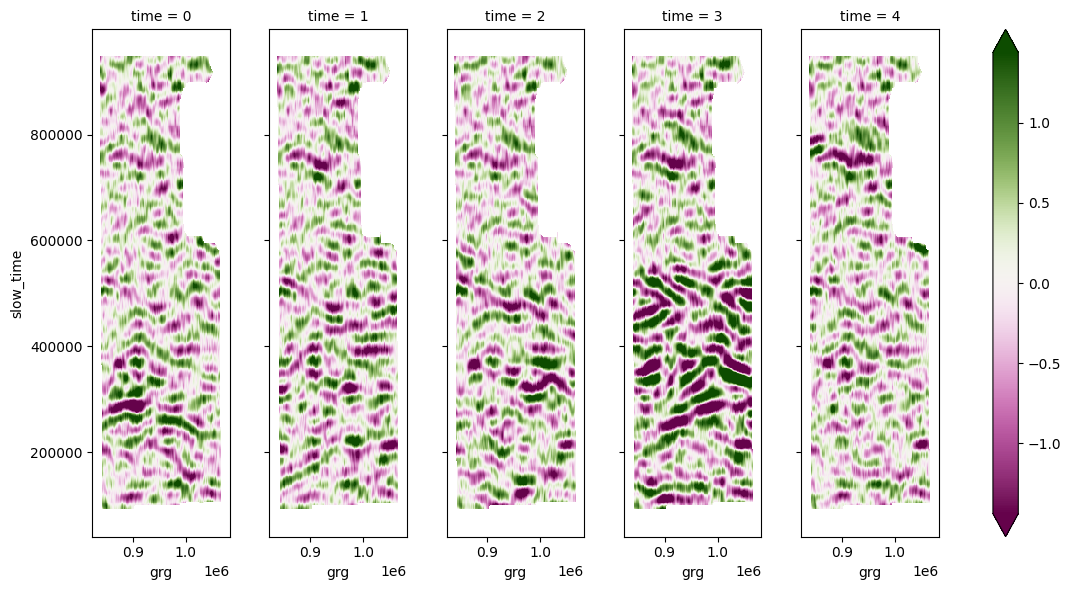

In [30]:
a = ds_noise.plot(x='grg', y = 'slow_time', col = 'time', robust = True, cmap = cmc.bam, figsize = (12,6))
_ = [ax.axes.set_aspect('equal') for ax in a.axs.ravel()]

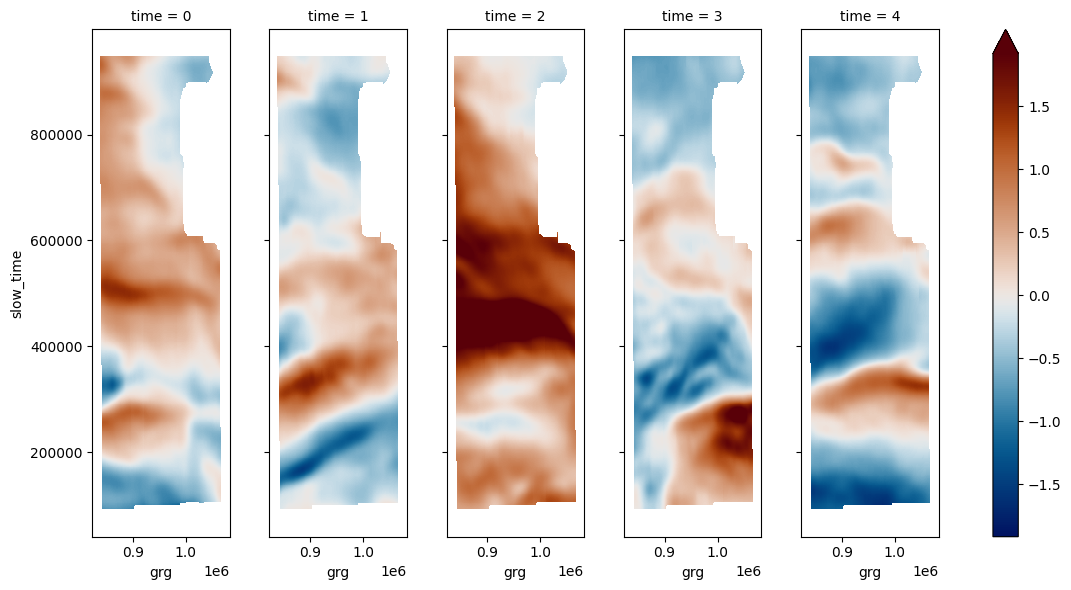

In [31]:
a = ds_signal.plot(x='grg', y = 'slow_time', col = 'time', robust = True, cmap = cmc.vik, figsize = (12,6))
_ = [ax.axes.set_aspect('equal') for ax in a.axs.ravel()]

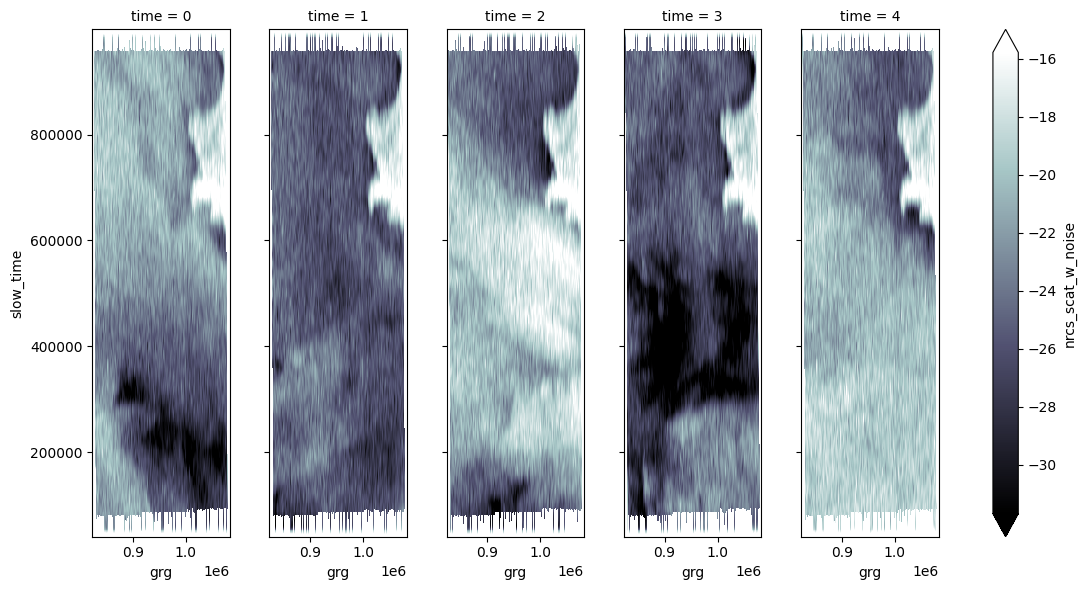

In [32]:
a = (10*np.log10(ds_nrcs)).plot(x='grg', y = 'slow_time', col = 'time', robust = True, cmap = 'bone', figsize = (12,6))
_ = [ax.axes.set_aspect('equal') for ax in a.axs.ravel()]